# Module 2 — Dataset Preparation, Annotation (VIA) & Management — Expanded

This notebook demonstrates:

- creating a small synthetic image dataset with folder structure
- creating CSV labels and reading them
- building `tf.data` and PyTorch `Dataset` pipelines
- an example VIA (VGG Image Annotator) JSON structure and conversion to YOLO TXT format
- saving a simple TFRecord for classification (example)

Run cells sequentially in Colab. This notebook is classroom-friendly and uses small synthetic data so cells run quickly.

Let’s continue with **Module 2: Dataset Preparation & Annotation** in a classroom-friendly, hands-on way. Below I’ll walk through the recommended lesson flow, show short runnable code snippets (ready for Colab), explain annotation formats (VIA ↔ YOLO ↔ COCO), give best practices, and finish with in-class exercises and common pitfalls instructors should highlight.

# Module 2 — Dataset Preparation & Annotation (classroom flow)

---

## 1) Learning goals (what students should take away)

* Understand proper folder / CSV dataset layouts for classification and detection.
* Create small reproducible datasets (train/val/test) and load them in `tf.data` and PyTorch `Dataset`.
* Annotate images with VIA (VGG Image Annotator) and export to common formats.
* Convert VIA output to YOLO and COCO (simple utilities).
* Save a TFRecord (classification example) and know why this helps for large datasets.

---

## 2) Folder structures (simple, resilient)

**Classification (recommended)**:

```
dataset/
  train/
    classA/
      img1.jpg
      img2.jpg
  val/
    classA/
    classB/
  test/
    ...
```

**Detection (YOLO-style)**:

```
yolo_dataset/
  images/
    train/
      0001.jpg
    val/
      0002.jpg
  labels/
    train/
      0001.txt    # YOLO line(s): <class> <xc> <yc> <w> <h>   (normalized)
    val/
      0002.txt
  data.yaml         # points to images/train and images/val, lists nc and names
```

---

## 3) Quick runnable examples

### 3.1 Create a small synthetic classification dataset (Colab-ready)

```python
# creates tiny dataset on disk (run in Colab / local)
import os
from PIL import Image, ImageDraw
os.makedirs('/content/dataset/train/cat', exist_ok=True)
os.makedirs('/content/dataset/train/dog', exist_ok=True)

def make_image(path, label):
    im = Image.new('RGB', (128,128), (255,255,255))
    d = ImageDraw.Draw(im)
    if label=='cat':
        d.ellipse((30,30,98,98), fill=(200,100,200))
    else:
        d.rectangle((30,30,98,98), fill=(100,200,100))
    im.save(path)

for i in range(20):
    make_image(f'/content/dataset/train/cat/cat_{i}.jpg','cat')
    make_image(f'/content/dataset/train/dog/dog_{i}.jpg','dog')
```

### 3.2 Create CSV mapping (useful for programmatic pipelines)

```python
import pandas as pd, os, glob
rows=[]
for split in ['train']:
    for label in ['cat','dog']:
        for fn in glob.glob(f'/content/dataset/{split}/{label}/*.jpg'):
            rows.append({'filepath': fn, 'label': label, 'split': split})
df = pd.DataFrame(rows)
df.to_csv('/content/dataset/labels.csv', index=False)
df.head()
```

### 3.3 `tf.data` pipeline (read from CSV)

```python
import tensorflow as tf
import pandas as pd

df = pd.read_csv('/content/dataset/labels.csv')
def load_fn(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128,128]) / 255.0
    return image, label

paths = df['filepath'].values
labels = df['label'].map({'cat':0,'dog':1}).values
ds = tf.data.Dataset.from_tensor_slices((paths, labels)).map(
        lambda p,l: tf.py_function(load_fn, [p,l], [tf.float32, tf.int64]),
        num_parallel_calls=tf.data.AUTOTUNE
     ).batch(16).prefetch(tf.data.AUTOTUNE)
```

> **Note:** for production, avoid `py_function` (slower) — use TF ops to read and decode directly when paths are strings.

### 3.4 PyTorch `Dataset` example

```python
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

class ImgDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.label_map = {'cat':0,'dog':1}
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        im = Image.open(row['filepath']).convert('RGB').resize((128,128))
        arr = torch.tensor(np.array(im).transpose(2,0,1), dtype=torch.float32) / 255.0
        lbl = torch.tensor(self.label_map[row['label']], dtype=torch.long)
        return arr, lbl

# usage:
# ds = ImgDataset(df)
# loader = DataLoader(ds, batch_size=8, shuffle=True)
```

---

## 4) Annotation with VIA (VGG Image Annotator)

### Quick instructor flow

1. Open VIA: [https://www.robots.ox.ac.uk/~vgg/software/via/](https://www.robots.ox.ac.uk/~vgg/software/via/)
2. Click **Add Files** → upload images.
3. Use **Rectangle** (or polygon) tool to draw bounding boxes.
4. In **Region Attributes**, enter label/class (e.g., `diseased`).
5. After annotating, click **Project → Save** and download `via_region_data.json`.

**VIA JSON structure** (simplified):

```json
{
  "img1.jpg": {
    "filename":"img1.jpg",
    "size":12345,
    "regions":[
      {"shape_attributes":{"name":"rect","x":10,"y":20,"width":50,"height":40},
       "region_attributes":{"label":"diseased"}}
    ]
  }
}
```

---

## 5) Converting VIA JSON -> YOLO format (simple Python utility)

YOLO expects each image to have a `.txt` file with lines:

```
<class_idx> <x_center_norm> <y_center_norm> <width_norm> <height_norm>
```

Example conversion:

```python
import json, os
with open('/content/via_region_data.json') as f:
    via = json.load(f)

img_w, img_h = 1280, 720  # replace with actual image sizes
label_map = {'diseased':0, 'healthy':1}

out_dir = '/content/yolo_labels'
os.makedirs(out_dir, exist_ok=True)

for key,val in via.items():
    fname = val['filename']
    txt_lines=[]
    for region in val.get('regions', []):
        sa = region['shape_attributes']
        ra = region['region_attributes']
        x,y,w,h = sa['x'],sa['y'],sa['width'],sa['height']
        xc = (x + w/2)/img_w
        yc = (y + h/2)/img_h
        nw = w/img_w; nh = h/img_h
        cls = label_map[ra['label']]
        txt_lines.append(f"{cls} {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")
    with open(os.path.join(out_dir, os.path.splitext(fname)[0]+'.txt'),'w') as wf:
        wf.write("\n".join(txt_lines))
```

> **Important:** compute `img_w,img_h` per image (read image size) — VIA does not always include image dimensions.

---

## 6) VIA → COCO (brief guidance)

* COCO is more complex (JSON with `images`, `annotations`, `categories`).
* For larger projects, use conversion scripts (many exist on GitHub). The conversion requires:

  * `images` list with id, width, height, filename
  * `annotations` list with bbox `[x,y,w,h]`, `area`, `category_id`, `image_id`
* I can provide a ready utility if you want; for classroom, converting to YOLO is often simpler.

---

## 7) Roboflow workflow (recommended for non-coders / faster pipeline)

* Roboflow handles uploads, annotation, augmentation, train/val split, and exports:

  1. Create Roboflow account → New Project → Upload images (or import VIA JSON).
  2. Annotate online or import your VIA file.
  3. Configure preprocessing: resize (e.g., 416×416), augmentations, and split ratio.
  4. Export → choose format (YOLOv5/YOLOv8 / COCO / TFRecord / etc.)
  5. Download zip and either train on Roboflow or in Colab locally.
* **Instructor tip:** for demos, use Roboflow to generate train/val/test zip and include `data.yaml` they provide — very quick.

---

## 8) TFRecord export (classification example)

Saving TFRecords helps for large datasets and performant `tf.data` pipelines:

```python
import tensorflow as tf
def _bytes_feature(b): return tf.train.Feature(bytes_list=tf.train.BytesList(value=[b]))
def _int_feature(i): return tf.train.Feature(int64_list=tf.train.Int64List(value=[i]))

with tf.io.TFRecordWriter('/content/train.tfrecord') as w:
    for _, row in df.iterrows():
        img_bytes = open(row['filepath'],'rb').read()
        label = 0 if row['label']=='cat' else 1
        feat = {
            'image': _bytes_feature(img_bytes),
            'label': _int_feature(label)
        }
        ex = tf.train.Example(features=tf.train.Features(feature=feat))
        w.write(ex.SerializeToString())
```

Then read TFRecord with `tf.data` (faster, binary).

---

## 9) Best practices & instructor tips

* **Small sample for demos**: prepare a 50–200 image subset so students can run training in-class.
* **Canonical splits**: use `train/val/test` — don’t reuse val as test.
* **Class balance**: show distribution and explain effects on accuracy.
* **Filename stability**: avoid spaces and special characters in filenames.
* **Store annotations with images**: keep relative paths consistent when zipping/exporting.
* **Version control annotations**: annotate a small set in class and show effect of better/worse annotations on model results.
* **Backing up**: encourage students to upload images and annotations to Drive or GitHub (small datasets) before class.

---

## 10) In-class exercises (progressive)

1. **Hands-on VIA**: annotate 10 images, export VIA JSON, convert to YOLO, and display a labeled image using predicted bounding boxes read from `.txt`.
2. **tf.data vs disk**: create two pipelines: (A) load images directly from paths in CSV (B) precompute TFRecord — compare iteration speed.
3. **Roboflow trial**: upload dataset to Roboflow, try a couple of augmentation settings, export YOLOv8, and train a tiny model.
4. **Annotation QA**: create intentionally noisy annotations (shift boxes slightly) and show how mAP drops on detection training.

---

## 11) Common pitfalls to highlight in class

* Wrong coordinate normalization when converting VIA→YOLO (remember YOLO expects normalized center & size).
* Using inconsistent image sizes without updating label coords.
* Overwriting label files accidentally (naming collisions).
* Mixing absolute and normalized coordinates in the same pipeline.
* Not shuffling before splitting (time-series or grouped data need stratified or grouped split).

---

## 12) Quick checklists for instructors

* Prepare a zipped dataset with a small subset for students to download (and a full dataset for homework).
* Pre-run heavy tasks (full training) and upload checkpoints for demo inference.
* Provide conversion utilities (VIA→YOLO, VIA→CSV, CSV→TFRecord) in the repo for students to reuse.

---

## 1 — Setup (install packages and imports)

In [24]:
# Install PyTorch (cpu) and torchvision if not present
!pip -q install -U torch torchvision --quiet

import os, shutil, random, json
from PIL import Image, ImageDraw, ImageFont
import numpy as np, pandas as pd
print('Ready — created required libraries')

Ready — created required libraries


In [25]:
# 🧩 Clean install of Torch + compatible Pillow
!pip install -U torch torchvision pillow==11.0.0 --quiet

import os, shutil, random, json
from PIL import Image, ImageDraw, ImageFont
import numpy as np, pandas as pd

print("✅ Environment ready — libraries loaded successfully.")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires torch<2.9,>=1.10, but you have torch 2.9.0 which is incompatible.
✅ Environment ready — libraries loaded successfully.


In [26]:
!pip install --upgrade --force-reinstall "pillow==9.5.0"


  Using cached Pillow-9.5.0-cp312-cp312-linux_x86_64.whl
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires pillow>=10.1, but you have pillow 9.5.0 which is incompatible.
fastai 2.8.4 requires torch<2.9,>=1.10, but you have torch 2.9.0 which is incompatible.


Created synthetic dataset at /mnt/data/sample_dataset
Train images: 80
Val images: 20


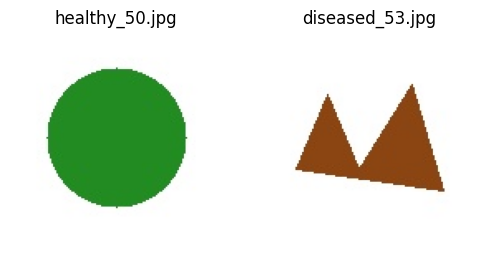

In [27]:
# Recommended fix: create images as numpy arrays and save with cv2.imwrite
import os, cv2, numpy as np, glob

root = '/mnt/data/sample_dataset'
train_dir = os.path.join(root, 'train')
val_dir = os.path.join(root, 'val')
for d in [train_dir, val_dir]:
    os.makedirs(os.path.join(d, 'healthy'), exist_ok=True)
    os.makedirs(os.path.join(d, 'diseased'), exist_ok=True)

def make_image_cv2(path, label, size=(128,128)):
    h, w = size
    # white background
    img = np.ones((h, w, 3), dtype=np.uint8) * 255

    if label == 'healthy':
        # draw green filled circle (center at 64,64 radius 34)
        center = (w//2, h//2)
        radius = min(h, w)//3
        color = (34, 139, 34)   # RGB
        # cv2 uses BGR, so convert when writing — we'll convert below
        cv2.circle(img, center, radius, color, thickness=-1)
    else:
        # draw a brown polygon to simulate disease
        pts = np.array([
            [int(w*0.15), int(h*0.65)],
            [int(w*0.3), int(h*0.3)],
            [int(w*0.45), int(h*0.65)],
            [int(w*0.7), int(h*0.25)],
            [int(w*0.85), int(h*0.75)]
        ], np.int32)
        pts = pts.reshape((-1, 1, 2))
        color = (139, 69, 19)  # RGB
        cv2.fillPoly(img, [pts], color)

    # cv2.imwrite expects BGR order, convert RGB->BGR
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    ok = cv2.imwrite(path, img_bgr)
    if not ok:
        raise IOError(f"cv2 failed to write {path}")

# create 80 train and 20 val images
for i in range(80):
    lbl = 'healthy' if i % 2 == 0 else 'diseased'
    out_path = os.path.join(train_dir, lbl, f'{lbl}_{i}.jpg')
    make_image_cv2(out_path, lbl)

for i in range(20):
    lbl = 'healthy' if i % 2 == 0 else 'diseased'
    out_path = os.path.join(val_dir, lbl, f'{lbl}_{i}.jpg')
    make_image_cv2(out_path, lbl)

print('Created synthetic dataset at', root)
print('Train images:', sum(len(files) for _,_,files in os.walk(os.path.join(root,'train'))))
print('Val images:', sum(len(files) for _,_,files in os.walk(os.path.join(root,'val'))))

# Quick visual check (use matplotlib in notebook)
import matplotlib.pyplot as plt
sample_healthy = glob.glob(os.path.join(train_dir,'healthy','*.jpg'))[:1]
sample_diseased = glob.glob(os.path.join(train_dir,'diseased','*.jpg'))[:1]
plt.figure(figsize=(6,3))
for i, p in enumerate(sample_healthy + sample_diseased):
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(1,2,i+1); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(p))
plt.show()


## 2 — Create synthetic dataset (classification) with folder structure

## 3 — Create CSV labels and load with pandas

In [28]:
# Create a CSV mapping for train and val
rows = []
for split in ['train','val']:
    for lbl in ['healthy','diseased']:
        folder = os.path.join(root, split, lbl)
        for f in sorted(os.listdir(folder)):
            rows.append({'filepath': os.path.join(split,lbl,f), 'label': lbl, 'split': split})

df = pd.DataFrame(rows)
df.to_csv('/mnt/data/sample_dataset_labels.csv', index=False)
print('Saved CSV to /mnt/data/sample_dataset_labels.csv')
df.head()


Saved CSV to /mnt/data/sample_dataset_labels.csv


,filepath,label,split
0,train/healthy/healthy_0.jpg,healthy,train
1,train/healthy/healthy_10.jpg,healthy,train
2,train/healthy/healthy_12.jpg,healthy,train
3,train/healthy/healthy_14.jpg,healthy,train
4,train/healthy/healthy_16.jpg,healthy,train


## 4 — `tf.data` pipeline for classification (reads from folder using CSV)

In [29]:
import tensorflow as tf
labels_df = pd.read_csv('/mnt/data/sample_dataset_labels.csv')

def make_tf_dataset(df, batch_size=16, training=False):
    filepaths = df['filepath'].apply(lambda p: os.path.join('/mnt/data/sample_dataset', p)).values
    labels = df['label'].map({'healthy':0,'diseased':1}).values
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    def _load(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [128,128])
        img = img/255.0
        if training:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.1)
        return img, label
    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_df = labels_df[labels_df['split']=='train']
val_df = labels_df[labels_df['split']=='val']
train_ds = make_tf_dataset(train_df, training=True)
val_ds = make_tf_dataset(val_df, training=False)

# quick iteration to show shapes
for imgs, lbls in train_ds.take(1):
    print('Batch images shape:', imgs.shape, 'labels shape:', lbls.shape)


Batch images shape: (16, 128, 128, 3) labels shape: (16,)


## 5 — Quick train a small Keras classifier on the synthetic dataset

In [30]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Input((128,128,3)),
    layers.Conv2D(16,3,activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'), layers.MaxPooling2D(),
    layers.Flatten(), layers.Dense(64, activation='relu'), layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=4)


Epoch 1/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - accuracy: 0.7431 - loss: 4.0781 - val_accuracy: 1.0000 - val_loss: 0.2812
Epoch 2/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6708 - loss: 0.8548 - val_accuracy: 0.5000 - val_loss: 0.9158
Epoch 3/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3389 - loss: 1.0873 - val_accuracy: 1.0000 - val_loss: 0.1795
Epoch 4/4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0719 - val_accuracy: 1.0000 - val_loss: 0.0623


## 6 — PyTorch `Dataset` and `DataLoader` example (classification)

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SimpleImageDataset(Dataset):
    def __init__(self, df, root_dir='/mnt/data/sample_dataset', transform=None):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform
        self.label_map = {'healthy':0,'diseased':1}
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row['filepath'])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = self.label_map[row['label']]
        return img, label

transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
train_dataset = SimpleImageDataset(train_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# show one batch
imgs, labels = next(iter(train_loader))
print('Torch batch shape:', imgs.shape, labels)


Torch batch shape: torch.Size([8, 3, 128, 128]) tensor([0, 1, 0, 0, 1, 0, 0, 0])


## 7 — VIA (VGG Image Annotator) JSON example and conversion to YOLO TXT format

This section shows a small example of VIA JSON structure and a utility to convert bounding boxes to YOLO TXT format (normalized xc yc w h). In-class: instructors can open VIA in browser, annotate few images, download `via_region_data.json` and upload to Colab, then run conversion code below.

In [32]:
# Example VIA JSON structure for one image (simulated)
via_example = {
    'sample1.jpg': {
        'filename': 'sample1.jpg',
        'size': 12345,
        'regions': [
            {'shape_attributes': {'name':'rect','x':10,'y':20,'width':50,'height':40}, 'region_attributes': {'label':'diseased'}}
        ]
    }
}
# Save example file
json_path = '/mnt/data/via_example.json'
with open(json_path,'w') as f:
    json.dump(via_example, f)
print('Saved example VIA json to', json_path)

# Utility: convert VIA json to YOLO txt files
with open(json_path) as f:
    via = json.load(f)

# Suppose images are 128x128 as created earlier
img_w, img_h = 128, 128
os.makedirs('/mnt/data/via_yolo', exist_ok=True)
for key, val in via.items():
    fname = val['filename']
    base, _ = os.path.splitext(fname)
    yolo_lines = []
    for reg in val.get('regions', []):
        sa = reg['shape_attributes']
        x, y, w, h = sa['x'], sa['y'], sa['width'], sa['height']
        # compute normalized xc yc w h
        xc = (x + w/2) / img_w
        yc = (y + h/2) / img_h
        nw = w / img_w
        nh = h / img_h
        cls = 0  # example: diseased->0 mapping
        yolo_lines.append(f"{cls} {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")
    # write to txt
    with open(f'/mnt/data/via_yolo/{base}.txt','w') as out:
        out.write('\n'.join(yolo_lines))
print('Converted VIA example to YOLO format in /mnt/data/via_yolo')


Saved example VIA json to /mnt/data/via_example.json
Converted VIA example to YOLO format in /mnt/data/via_yolo


## 8 — Save a simple TFRecord for classification (example)

In [33]:
# Save train split as TFRecord (image bytes + label)
import tensorflow as tf
train_records = '/mnt/data/train_classification.tfrecord'

with tf.io.TFRecordWriter(train_records) as writer:
    for _, row in train_df.iterrows():
        path = os.path.join('/mnt/data/sample_dataset', row['filepath'])
        img_bytes = open(path,'rb').read()
        label = 0 if row['label']=='healthy' else 1
        feature = {
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_bytes])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }
        ex = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(ex.SerializeToString())
print('Saved TFRecord to', train_records)


Saved TFRecord to /mnt/data/train_classification.tfrecord


## 9 — Instructor Notes & Exercises

- Replace synthetic images with real dataset and reuse same CSV structure.
- In-class exercise: annotate 10 images in VIA (https://www.robots.ox.ac.uk/~vgg/software/via/), download via_region_data.json, upload to Colab and run the conversion cell to produce YOLO annotations.
- Demonstrate Roboflow by uploading dataset to Roboflow (online) and export in YOLOv8 format for training.
- Homework: convert VIA JSON to COCO format (advanced) and train a segmentation/detection model using the generated annotations.